In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft2, fft2, fftshift
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

def opt_plot():
    plt.grid(True, linestyle = ':', color = '0.50')
    plt.rcParams['font.family'] = 'monospace'
    plt.rcParams['font.size'] = 15
    plt.minorticks_on()
    plt.tick_params(axis = 'both', which = 'minor', direction = "in",
                        top = True, right = True, length = 5, width = 1, labelsize = 15)
    plt.tick_params(axis = 'both', which = 'major', direction = "in",
                        top = True, right = True, length = 8, width = 1, labelsize = 15)
    
import warnings
warnings.filterwarnings('ignore')

In [31]:
def NDFT(M, xn):
    
    N = len(xn)
            
    ndft = np.zeros((M, N), complex)
        
    for m in np.arange(M):
        for n in range(N):
            ndft[m, n] = (1./N)*np.exp(-2j*np.pi*m*xn[n])
    
    return ndft

def sinal_de_teste(t):
    sinal = np.sin(5*2*np.pi*t) + 0.3*np.sin(8*2*np.pi*t) + 0.6*np.sin(16*2*np.pi*t)
    return sinal

In [35]:
N = 300
t0 = 0.
tf = 3.
dt = (tf-t0)/N
deltak = 2*np.pi/(tf-t0)

t = np.linspace(t0, tf, N)
sinal_teste = sinal_de_teste(t)
freq = np.linspace(-1./(2*dt),1./(2*dt),N)

In [36]:
fk_espectro_original = np.fft.fftshift(np.fft.fft(sinal_teste, norm='forward'))

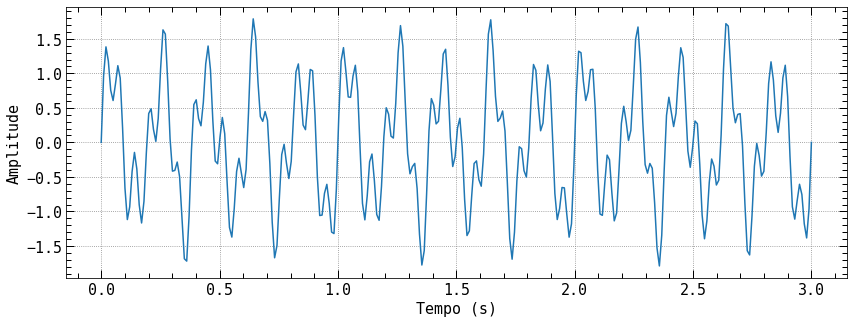

In [37]:
plt.figure(figsize=(14,5))

plt.plot(t, sinal_teste)
plt.ylabel('Amplitude')
plt.xlabel('Tempo (s)')
opt_plot()
plt.savefig("Sinal-origianal-cap3.jpg")
plt.show()

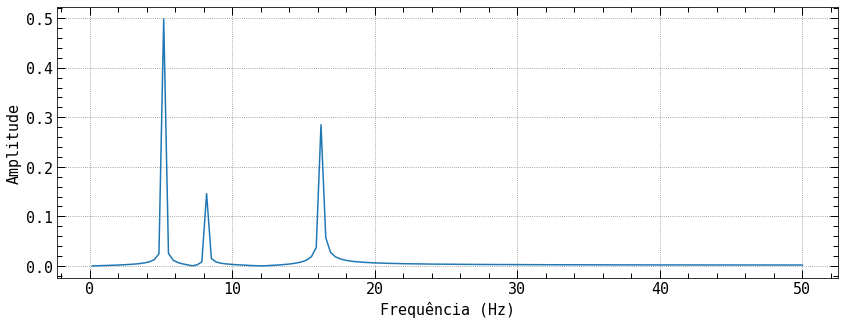

In [6]:
plt.figure(figsize=(14,5))
plt.plot(freq[N//2:N], abs(fk_espectro_original[N//2:N]))
plt.ylabel('Amplitude')
plt.xlabel('Frequência (Hz)')
opt_plot()
plt.savefig("Espectro-original-cap3.jpg")
plt.show()

In [7]:
def signal_decimado(sinal, pontos):
    
    sinal_conhecido = []
    pontos_conhecidos = []
    idx = []
    n = 0
    idx.append(n)
    while n < len(pontos) - 11:
        if n < len(pontos):
            i = np.random.choice(np.arange(n+1, n+12, 1),size=1)
            idx.append(i[0])
        n = i[0]
  
    for i in idx:
        sinal_conhecido.append(sinal[i])
    for j in idx:
        pontos_conhecidos.append(pontos[j])
        
    return np.array(sinal_conhecido), np.array(pontos_conhecidos)

sinal_decimado, amostras_decimadas = signal_decimado(sinal_teste, t)

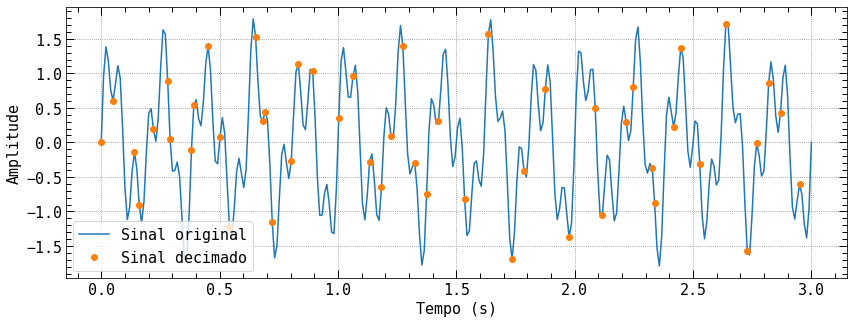

In [8]:
plt.figure(figsize=(14,5))

plt.plot(t, sinal_teste, label='Sinal original')
plt.plot(amostras_decimadas, sinal_decimado,'o', label='Sinal decimado')
plt.ylabel('Amplitude')
plt.xlabel('Tempo (s)')
plt.legend()
plt.savefig("Dado-decimado-cap3.jpg")
opt_plot()

In [9]:
def delta_t_medio(amostragem):
    
    N = len(amostragem)
    mt = 0
    for i in range(1,N):
        mt+=amostragem[i]-amostragem[i-1]
    mt = mt/N
    
    return round(mt,2)

In [10]:
print(f'Número de pontos conservados : {len(sinal_decimado)}')
print(f'taxa de amostragem média : {delta_t_medio(amostras_decimadas)}')

Número de pontos conservados : 49
taxa de amostragem média : 0.06


In [11]:
F_ndft = NDFT(N, amostras_decimadas/tf)

In [12]:
fk_espectro_ndft = np.fft.fftshift(np.dot(F_ndft, sinal_decimado))

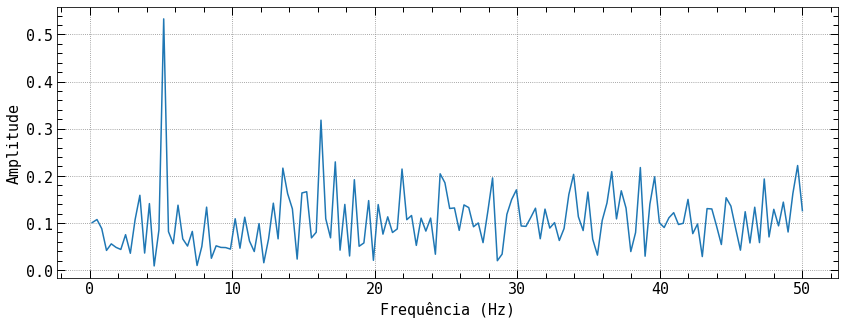

In [13]:
plt.figure(figsize=(14,5))
plt.plot(freq[N//2:N], abs(fk_espectro_ndft[N//2:N]))
plt.ylabel('Amplitude')
plt.xlabel('Frequência (Hz)')
opt_plot()
plt.savefig("Espectro-do-dado-decimado-cap3.jpg")
plt.show()

In [14]:
def MPFI(dictionary, y , epsilon):

    r = y
    num_ite = 0
    size_col_dictionary = dictionary.shape[1]
    indices = np.array([])
    x = np.zeros((size_col_dictionary,), complex)
    
    lambd = []
    espec_atl = []
    resid_atl = []
    signal_ani = []
    norm_resid = []
    new_espec_atl = np.zeros((1000,size_col_dictionary), complex)

    while ( np.linalg.norm(r , ord=2) >= epsilon):
        
        resid_atl.append(r)
        norm_resid.append(np.linalg.norm(r , ord=2))
        new_espec_atl[num_ite,:] = x
        absolute_fourier_domain = abs(np.dot(dictionary.T, r)) # Indo para o espaço da transformada

        max_freq_fourier_domain = max(absolute_fourier_domain) # Pegando a frequência com maior valor absoluto

        indices = np.where( absolute_fourier_domain == max_freq_fourier_domain )[0]

        atoms_selected = dictionary[:, indices]

        coef_max_value = np.dot(atoms_selected.T, r) 

        x[ indices ] = x[ indices ] + coef_max_value # Guardando as frequências
        r = r - np.dot(coef_max_value, len(y)*np.conjugate(atoms_selected.T)) # Atualizando o sinal
        
        espec_atl.append(absolute_fourier_domain)
        signal_ani.append(np.dot(len(y)*np.conjugate(dictionary),x))
        num_ite+=1
    
    return x, espec_atl, resid_atl, new_espec_atl, signal_ani, num_ite, norm_resid

In [15]:
tol = 0.001
novo_espec_mp, ani_mp, resid_mp, ani_newespec_mp, signal_ani_mp, num_ite_mp, norm_residual_mp = MPFI(F_ndft.T, sinal_decimado, tol)

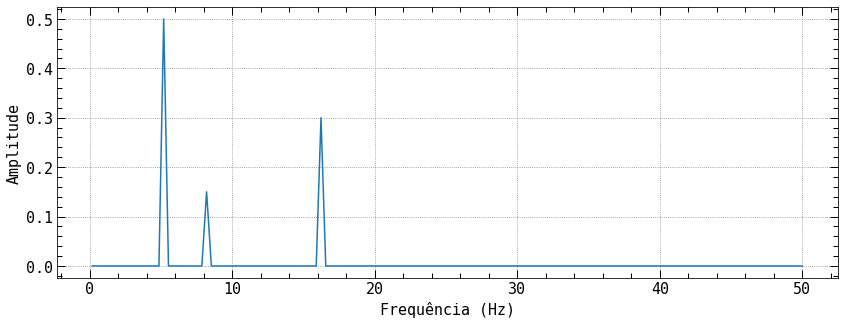

In [16]:
plt.figure(figsize=(14,5))

plt.plot(freq[N//2:N], abs(np.fft.fftshift(novo_espec_mp))[N//2:N])
plt.ylabel('Amplitude')
plt.xlabel('Frequência (Hz)')
opt_plot()
plt.savefig("Espectro-recuperado-MP-cap3.jpg")
plt.show()

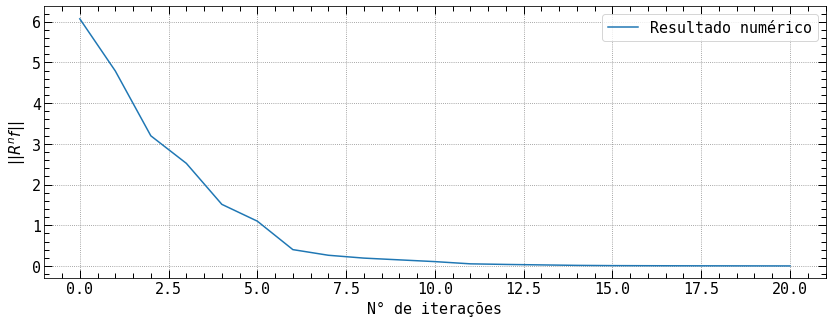

In [17]:
def normaresidual(sinal_decimado, ite):
    
    N = len(sinal_decimado)
    fn = np.linalg.norm(sinal_decimado , ord=2)
    print(fn)
    
    nr = np.zeros(ite, float)
    for i in range(ite):
        nr[i] = (1 - 1/44)**(i/2)
    return fn*nr

plt.figure(figsize=(14,5))

plt.plot(norm_residual_mp, label='Resultado numérico')
plt.ylabel('$||R^{n}f||$')
plt.xlabel('N° de iterações')
opt_plot()
plt.legend()
plt.savefig('Norma-MP-cap3.jpg')
plt.show()

In [18]:
iF_ndft = N*np.conjugate(NDFT(N, t/tf)).T

sinal_mp = np.dot(iF_ndft, novo_espec_mp)

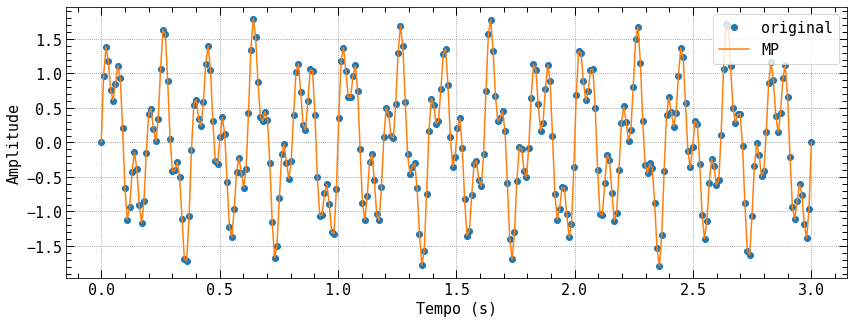

In [19]:
plt.figure(figsize=(14,5))

plt.plot(t, sinal_teste, 'o', label='original')
plt.plot(t, sinal_mp.real, label='MP')
plt.ylabel('Amplitude')
plt.xlabel('Tempo (s)')
plt.legend()
opt_plot()
plt.savefig("sinal-recuperado-MP-cap3.jpg")

MovieWriter ffmpeg unavailable; using Pillow instead.


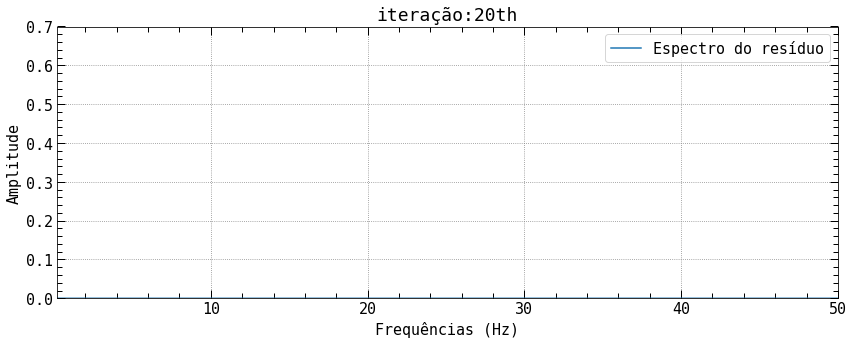

In [20]:
import matplotlib.animation as animation

fig, ax = plt.subplots(1, figsize=(14,5))

plt_datamp, = ax.plot([], [], label='Espectro do resíduo')

ax.set_ylabel('Amplitude')
ax.set_xlabel('Frequências (Hz)')
ax.set_ylim(0, 0.7)
ax.set_xlim(freq[N//2], freq[N-1])
ax.legend()


def animate(i):
    
    ax.set_title(f'iteração:{i}th')
   
    plt_datamp.set_data(freq, abs(np.fft.fftshift(ani_mp[i])))
    
    return plt_datamp

ani = animation.FuncAnimation(fig, animate, np.min([num_ite_mp,num_ite_mp]), interval=1000, blit=False, repeat=False)

opt_plot()
ani.save("animação_do_espectro.gif")
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


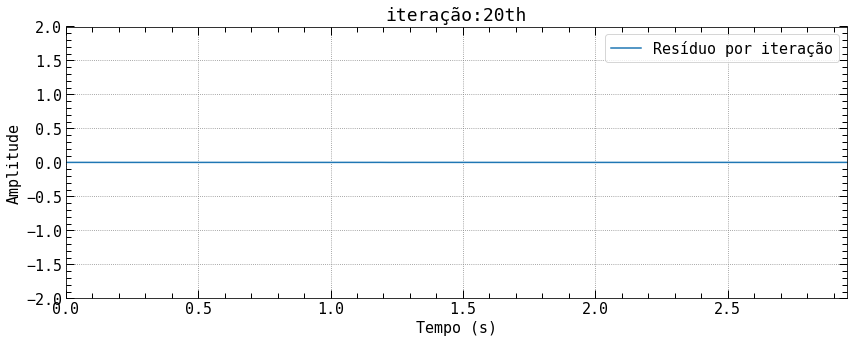

In [21]:
fig, ax = plt.subplots(1, figsize=(14,5))

plt_datamp, = ax.plot([], [], label='Resíduo por iteração')

ax.set_ylabel('Amplitude')
ax.set_xlabel('Tempo (s)')
ax.set_ylim(-2.0, 2.0)
ax.set_xlim(amostras_decimadas[0],amostras_decimadas[len(amostras_decimadas)-1])
ax.legend()

def animate(i):
    ax.set_title(f'iteração:{i}th')
    
    plt_datamp.set_data(amostras_decimadas, resid_mp[i].real)
    
    return plt_datamp

ani = animation.FuncAnimation(fig, animate, np.min([num_ite_mp,num_ite_mp]), interval=1000, blit=False, repeat=False)

opt_plot()
ani.save("animação_do_resíduo.gif")
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


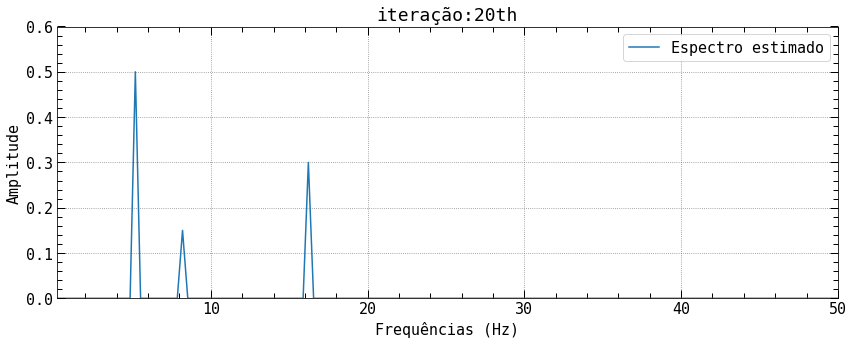

In [22]:
fig, ax = plt.subplots(1, figsize=(14,5))

plt_datamp, = ax.plot([], [], label='Espectro estimado')

ax.set_ylabel('Amplitude')
ax.set_xlabel('Frequências (Hz)')
ax.set_ylim(0, 0.6)
ax.set_xlim(freq[N//2], freq[N-1])
ax.legend()

def animate(i):
    ax.set_title(f'iteração:{i}th')
    
    plt_datamp.set_data(freq, abs(np.fft.fftshift(ani_newespec_mp[i,:])))
    
    return plt_datamp

ani = animation.FuncAnimation(fig, animate, num_ite_mp, interval=1000, blit=False, repeat=False)

opt_plot()
ani.save("animação_do_espectro_estimado.gif")
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


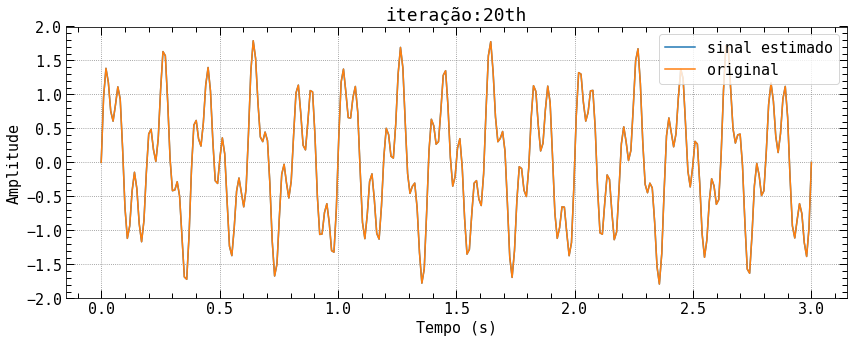

In [23]:
fig, ax = plt.subplots(1, figsize=(14,5))

plt_datamp, = ax.plot([], [], label='sinal estimado')

ax.plot(t, sinal_teste, label='original')
ax.set_ylabel('Amplitude')
ax.set_xlabel('Tempo (s)')
ax.set_ylim(-2, 2)
ax.legend()

def animate(i):
    ax.set_title(f'iteração:{i}th')
    
    plt_datamp.set_data(t, np.dot(iF_ndft, ani_newespec_mp[i,:]).real)
    
    return plt_datamp

ani = animation.FuncAnimation(fig, animate, num_ite_mp, interval=1000, blit=False, repeat=False)

opt_plot()
ani.save("animação_do_sinal_estimado.gif")
plt.show()

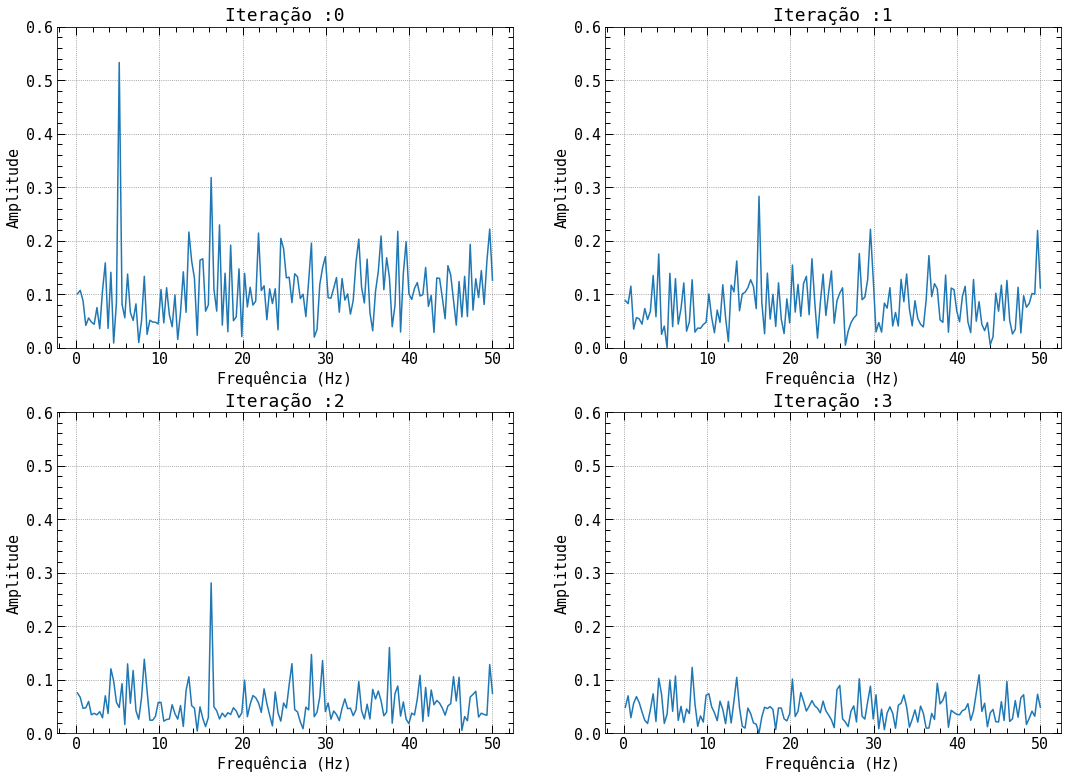

In [24]:
plt.figure(figsize=(18,13))

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(f'Iteração :{i}')
    plt.plot(freq[N//2:N], abs(np.fft.fftshift(ani_mp[i]))[N//2:N])
    plt.ylabel('Amplitude')
    plt.xlabel('Frequência (Hz)')
    plt.ylim(0, 0.6)
    opt_plot()
plt.savefig(f'espectro_loop_ite.jpg')

In [29]:
def RMS(sismograma, sismograma_interpolado):
    rsme = np.linalg.norm(sismograma - sismograma_interpolado, ord=2)/np.linalg.norm(sismograma, ord=2)
    return rsme

def SNR(sismograma, sismograma_interpolado):
    snr = 10*np.log10(np.linalg.norm(sismograma, ord=2)/np.linalg.norm((sismograma - sismograma_interpolado), ord=2))
    return snr

In [30]:
print(RMS(sinal_teste, sinal_mp.real)*100)
print(SNR(sinal_teste, sinal_mp.real))

0.011611906130427478
39.35096483622498
